In [1]:
!pip install PyDrive
!git clone https://github.com/LeCrunchic/colablib

    100% |████████████████████████████████| 993kB 8.5MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
Cloning into 'colablib'...
remote: Counting objects: 26, done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import anova_lm

from colablib.utilities import *

In [0]:
get_file('1-2tqeLrnAf9MUCUflQQi999w3hKte95F', 'filmData.csv')
data = pd.read_csv('filmData.csv')

In [0]:
# testing data
#group1 = np.array([1, 4, 3, 2, 5, 1, 6])
#group2 = np.array([8, 6, 7, 4, 3, 5])
#group3 = np.array([7, 6, 4, 9, 8, 5, 7, 5])
#group4 = np.array([9, 10, 8, 6, 5])
#group5 = np.array([10, 12, 9, 11, 8])

#bigGroup = np.array([group1, group2, group3, group4, group5])

def ss(groups, sstype='total'):
    """Sum of squares. By default calculates the total sum of squares."""
    vectorGroups = np.concatenate(tuple(x for x in groups))
    grandMean = np.sum(vectorGroups) / len(vectorGroups)
    
    def sst(groupsVector, totalMean):
        return np.sum(np.square(groupsVector - totalMean))
    
    def ssb(groups, totalMean):
        groupMeans = np.fromiter((np.mean(x) for x in groups), dtype=np.float32)
        groupLengths = np.fromiter((len(x) for x in groups), dtype=int)
        
        return np.sum(groupLengths * np.square(groupMeans - grandMean))
    
    if sstype == 'total':
        sst = sst(vectorGroups, grandMean)
        return sst
    
    if sstype == 'between':
        ssb = ssb(groups, grandMean)
        return ssb
    
    if sstype == 'within':
        ssw = sst(vectorGroups, grandMean) - ssb(groups, grandMean)
        return ssw

def ms(groups, mstype='between'):
    """Mean squares. By default calculates the between groups mean of squares"""
    numGroups = len(groups)
    
    if mstype == 'between':
        dfBetween = numGroups - 1
        ssb = ss(groups, sstype='between')
        return ssb / dfBetween
    
    if mstype == 'within':
        vectorGroups = np.concatenate(tuple(x for x in groups))
        numScores = len(vectorGroups)
        dfWithin = numScores - numGroups
        ssw = ss(groups, sstype='within')
        return ssw / dfWithin

def fstat(groups):              
    """F-value statistic. AKA ANOVA"""
    msb = ms(groups)
    msw = ms(groups, mstype='within')
    
    f = msb / msw
    return f

## Pre-Lab
Primary Research Questions

1. Does a film’s rating (PG, PG-13, or R) impact its cost to produce?
2. Does a film’s rating (PG, PG-13, or R) influence its IMDB score?


In [0]:
# fill NA in budget of R rating movie
data.loc[:, 'Budget'] = data['Budget'].fillna(data['Budget'].median())

In [0]:
ratingGroup = data.groupby('Rating')

### 1

In [7]:
ratingGroup.describe()['Budget']

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
PG,39.0,75.076923,46.460019,7.000000,30.25,79.0,115.0,155.0
PG13,94.0,127.074468,58.028773,6.000000,85.00,125.0,150.0,270.0
R,18.0,93.972080,55.348980,10.497444,53.25,85.0,137.5,200.0


In [0]:
budget_groups = np.array([group['Budget'].values for name, group in ratingGroup])

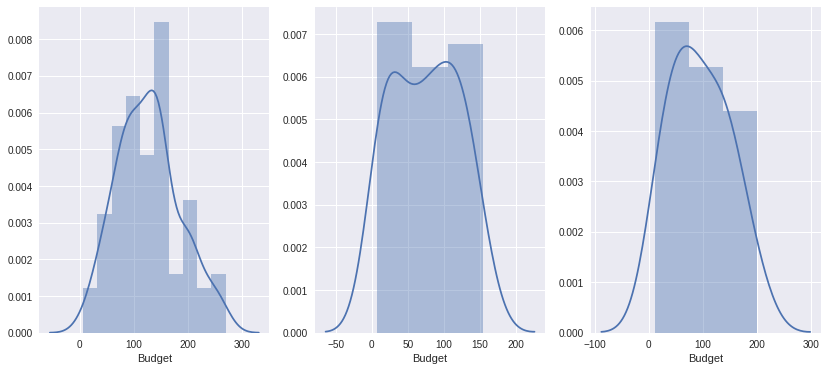

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

sns.distplot(ratingGroup.get_group('PG13')['Budget'], ax=ax[0])
sns.distplot(ratingGroup.get_group('PG')['Budget'], ax=ax[1])
sns.distplot(ratingGroup.get_group('R')['Budget'], ax=ax[2])

In [10]:
%%time
fstat(budget_groups)

CPU times: user 713 µs, sys: 732 µs, total: 1.45 ms
Wall time: 1.12 ms


13.166496896943872

In [11]:
%%time
print(f_oneway(budget_groups[0], budget_groups[1], budget_groups[2]))

F_onewayResult(statistic=13.166493004537246, pvalue=5.461083795886969e-06)
CPU times: user 951 µs, sys: 955 µs, total: 1.91 ms
Wall time: 1.59 ms


In [21]:
%%time

# the '~' in the formula means group Budget by Rating
# 'typ' is the type of ss (sum of squares) refer to 
# http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf for more on this

mod = smf.ols('Budget ~ Rating', data=data).fit()
aov_table = anova_lm(mod, typ=2)
print(aov_table)


                 sum_sq     df          F    PR(>F)
Rating     79580.136064    2.0  13.166493  0.000005
Residual  447266.410781  148.0        NaN       NaN
CPU times: user 16.9 ms, sys: 9.02 ms, total: 25.9 ms
Wall time: 24.6 ms


In [22]:
# tukey hsd
print(MultiComparison(data['Budget'], data['Rating']).tukeyhsd())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  PG    PG13  51.9975  27.2056  76.7895  True 
  PG     R    18.8952  -18.1942 55.9845 False 
 PG13    R    -33.1024 -66.5904  0.3856 False 
----------------------------------------------


### 2.

In [14]:
ratingGroup.describe()['IMDB']

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
PG,39.0,7.015385,1.013991,4.7,6.3,7.0,7.65,8.8
PG13,94.0,7.014894,0.821349,5.2,6.4,7.0,7.60,9.0
R,18.0,7.183333,0.667964,5.8,6.8,7.1,7.65,8.7


In [0]:
imdb_groups = np.array([group['IMDB'].values for name, group in ratingGroup])

In [69]:
fstat(imdb_groups)

0.30376307948149495

In [72]:
f_oneway(imdb_groups[0], imdb_groups[1], imdb_groups[2])

F_onewayResult(statistic=0.3037626970100247, pvalue=0.7384950055614831)

## Lab
1. Are some studios more successful in keeping their films in the theaters longer?
2. Do some studios earn a greater percentage of their earnings domestically than others?

### 1.

In [12]:
studioGrouping = data.groupby('Studio')
studioGrouping.describe()['Days']

,count,mean,std,min,25%,50%,75%,max
Studio,,,,,,,,
Fox,41.0,154.512195,36.184335,101.0,131.0,147.0,172.00,261.0
Par.,24.0,142.375000,44.925845,76.0,112.0,138.5,153.25,280.0
Sony,19.0,113.736842,28.446523,62.0,97.5,112.0,136.50,159.0
Uni.,27.0,130.370370,32.194300,56.0,108.0,134.0,148.00,196.0
WB,40.0,145.850000,29.738648,105.0,121.0,141.0,165.75,231.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec596ed320>,
      dtype=object)

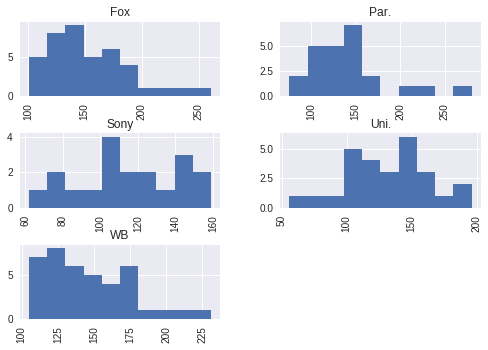

In [25]:
data.hist('Days', by='Studio')

In [88]:
modDays = smf.ols('Days ~ Studio', data=data).fit()
anovTable = anova_lm(modDays, typ=2)
print(anovTable)

AttributeError: ignored

In [22]:
print(MultiComparison(data['Days'], data['Studio']).tukeyhsd())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 Fox    Par.  -12.1372 -36.702  12.4276 False 
 Fox    Sony  -40.7754 -67.3007  -14.25  True 
 Fox    Uni.  -24.1418 -47.8302 -0.4535  True 
 Fox     WB   -8.6622  -29.9032 12.5788 False 
 Par.   Sony  -28.6382 -57.988   0.7117 False 
 Par.   Uni.  -12.0046 -38.818  14.8088 False 
 Par.    WB    3.475   -21.2029 28.1529 False 
 Sony   Uni.  16.6335  -11.9868 45.2539 False 
 Sony    WB   32.1132   5.483   58.7433  True 
 Uni.    WB   15.4796   -8.326  39.2853 False 
----------------------------------------------


Mean duration of Fox movies in theaters is significantly larger than the duration of both Sony and Universal's movies.

Also, Warner Brothers duration mean is significantly larger than Sony's.

### 2.

In [0]:
# patsy does not work well with the dot thing
data.rename(columns={'Pct.Dom': 'PctDom'}, inplace=True)

In [19]:
modDom = smf.ols('PctDom ~ Studio' , data=data).fit()
anovTabDom = anova_lm(modDom, typ=2)
print(anovTabDom)

            sum_sq     df         F    PR(>F)
Studio    0.093785    4.0  2.096621  0.084186
Residual  1.632694  146.0       NaN       NaN


In [14]:
studioGrouping.describe()['PctDom']

,count,mean,std,min,25%,50%,75%,max
Studio,,,,,,,,
Fox,41.0,0.410488,0.114375,0.184,0.3430,0.4140,0.48400,0.651
Par.,24.0,0.434250,0.105496,0.207,0.3910,0.4095,0.49200,0.668
Sony,19.0,0.360105,0.090748,0.216,0.2835,0.3600,0.42950,0.492
Uni.,27.0,0.439926,0.112772,0.236,0.3720,0.4150,0.50750,0.753
WB,40.0,0.395625,0.098000,0.243,0.3205,0.3620,0.46875,0.611


## Problem Set

### Q1
Do low-budget movies make a different percentage of their profits domestically than movies with medium- or high-budgets? 

Films with a Budget less than USD100 million are considered to be 'low budget'; films with a budget of USD100 million up to but not including USD150 million are considered 'medium budget' and those with a budget of USD150 million or more are considered 'high budget'

In [0]:
def budgetClass(r):
    if r['Budget'] >= 150:
        return 'high'
    
    elif (r['Budget'] >= 100) & (r['Budget'] < 150):
        return 'medium'
    
    return 'low'

func = lambda row: budgetClass(row)

In [0]:
data = data.assign(budgetClass = data.apply(func, axis=1))

In [26]:
budgetClassGroup = data.groupby('budgetClass')
budgetClassGroup.describe()['PctDom']

,count,mean,std,min,25%,50%,75%,max
budgetClass,,,,,,,,
high,42.0,0.375857,0.095338,0.216,0.30275,0.3595,0.42525,0.668
low,67.0,0.446194,0.102702,0.184,0.37450,0.4600,0.50250,0.651
medium,42.0,0.383714,0.109545,0.205,0.31325,0.3555,0.45850,0.753


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6959258710>,
      dtype=object)

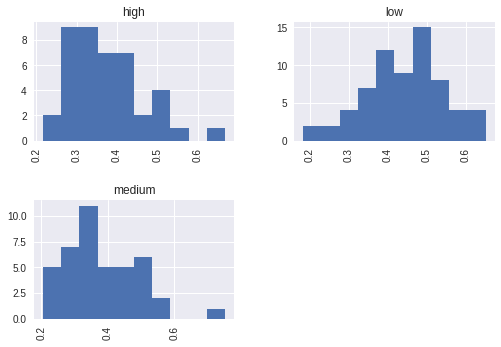

In [31]:
data.hist('PctDom', by='budgetClass')

In [28]:
# BC stands for Budget Class
modBC = smf.ols('PctDom ~ budgetClass', data=data).fit()
anovTableBC = anova_lm(modBC, typ=2)
print(anovTableBC)

               sum_sq     df         F    PR(>F)
budgetClass  0.165666    2.0  7.854438  0.000573
Residual     1.560812  148.0       NaN       NaN


In [29]:
print(MultiComparison(data['PctDom'], data['budgetClass']).tukeyhsd())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 high   low    0.0703   0.0225  0.1182  True 
 high  medium  0.0079  -0.0452  0.0609 False 
 low   medium -0.0625  -0.1103 -0.0146  True 
---------------------------------------------


### Q2
Forty-five (45) dog lovers are recruited for a study examining the calming effects of pets during stressful situations. 
Fifteen (15) subjects were randomly assigned to each of three different groups: 
- performing the task alone (control),
- performing the task with a good friend present, and
- performing the task with their dog present. 
The peak heart rate (in beats per minute) during the task was measured for each subject, with the following results: 

In [9]:
heartbeats = pd.DataFrame({'Group': np.array(['Alone', 'withFriend', 'withDog']), 'Mean': 
              np.array([82.52, 73.48, 91.32]), 'STD': np.array([9.24, 9.97, 8.34])})

heartbeats

,Group,Mean,STD
0,Alone,82.52,9.24
1,withFriend,73.48,9.97
2,withDog,91.32,8.34


 In this problem, you find that SStotal = 5949.1 and SSBetween = 2387.7. What is the F statistic for the test?

In [30]:
dfBetweenQ2 = 2 # number of groups minus 1
dfWithinQ2 = 42 # Total number of observations minus the number of groups

sstQ2 = 5949.1
ssbQ2 = 2387.7
sswQ2 = sstQ2 - ssbQ2

mswQ2 = sswQ2 / dfWithinQ2
msbQ2 = ssbQ2 / dfBetweenQ2

print('f-stat:', msbQ2 / mswQ2)

# REJECT

f-stat: 14.079210422867408


### Q3

A local police department has divided the city into three sections, and each is patrolled by a different set of six (6) officers.  The police chief wants to determine if officers are biased in the number of disorderly conduct tickets that they give out in each section.
Here are the number of tickets given by the officers in each section in the last week: 

In [27]:
ticketab = pd.DataFrame({'Section1': np.array([8, 4, 6, 8, 6, 4]), 
                         'Section2': np.array([3, 7, 0, 2, 7, 5]),
                         'Section3': np.array([1, 2, 7, 6, 5, 0])
                        }).melt(var_name = 'Section', value_name = 'Tickets')
ticketab

,Section,Tickets
0,Section1,8
1,Section1,4
2,Section1,6
3,Section1,8
4,Section1,6
5,Section1,4
6,Section2,3
7,Section2,7
8,Section2,0
9,Section2,2


What is SSTotal for this problem? 

In [31]:
grandMeanQ3 = ticketab['Tickets'].mean()
sstQ3 = np.sum(np.square(ticketab['Tickets'] - grandMeanQ3))
sstQ3

118.5

What is MSBetween for this problem?

In [40]:
dfBetweenQ3 = 2
groupMeansQ3 = ticketab.groupby('Section').mean()
groupLensQ3 = 6

ssbQ3 = np.sum(groupLensQ3 * np.square(groupMeansQ3 - grandMeanQ3).values)
msbQ3 = ssbQ3 / dfBetween

msbQ3

10.5

What is MSWithin for this problem? 

In [41]:
dfWithinQ3 = 15 # num of observ. - num of groups
sswQ3 = sstQ3 - ssbQ3

mswQ3 = sswQ3 / dfWithinQ3

mswQ3

6.5

What is the F statistic?

In [43]:
f_q3 = msbQ3 / mswQ3
f_q3

1.6153846153846154